In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# train = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
# train_og = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
# test = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
# sample_submission = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv')

In [3]:
train = pd.read_csv('train.csv')
train_og = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample.csv.csv')

# Exploratory Data Analysis
First i want to see what the data looks like. After that find any null values and decide how to manage them and also deal with outliers.

In [4]:
# train.head()

In [5]:
# train.describe()

In [6]:
# train.dtypes

In [7]:
# train.isnull().sum()

We can see that store_and_fwd_flag is "object" type and it has missing values. We will see what the values are and how many of them are missing.

In [8]:
# train['store_and_fwd_flag'].unique()

We can see that it is actually a string that essentially is a boolean value of true or false. We will convert it to a boolean value.

In [9]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N':False, 'Y':True})
# train['store_and_fwd_flag'].unique()

In [10]:
storenan = train[train['store_and_fwd_flag'].isnull()]
passengernan = train[train['passenger_count'].isnull()]
# storenan

In [11]:
# storenan.equals(passengernan)

Now this shows us that all rows with nan for store_and_fwd_flag are rows with the other missing values. For the first attempt we will put the mode in all the missing nan values.

In [12]:
train['store_and_fwd_flag'].fillna(train['store_and_fwd_flag'].mode()[0], inplace=True)
train['passenger_count'].fillna(train['passenger_count'].mode()[0], inplace=True)
train['RatecodeID'].fillna(train['RatecodeID'].mode()[0], inplace=True)
train['congestion_surcharge'].fillna(train['congestion_surcharge'].mode()[0], inplace=True)
train['Airport_fee'].fillna(train['Airport_fee'].mode()[0], inplace=True)

In [13]:
# train.isnull().sum()

In [14]:
import matplotlib.pyplot as plt
def get_vis():
    # Get the list of numerical columns
    numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
    if 'tpep_dropoff_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_dropoff_datetime')
    if 'tpep_pickup_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_pickup_datetime')
    if 'store_and_fwd_flag_False' in numerical_cols:
        numerical_cols = numerical_cols.drop('store_and_fwd_flag_False')
    if 'store_and_fwd_flag_True' in numerical_cols:
        numerical_cols = numerical_cols.drop('store_and_fwd_flag_True')
    if 'payment_type_Cash' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_Cash')
    if 'payment_type_Credit Card' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_Credit Card')
    if 'payment_type_UPI' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_UPI')
    if 'payment_type_Wallet' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_Wallet')
    if 'payment_type_unknown' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_unknown')

    # Set the number of columns for subplots
    n_cols = 6

    # Calculate the number of rows needed for subplots
    n_rows = (2 * len(numerical_cols) + n_cols - 1) // n_cols

    # Create a figure and axes with subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))

    for i, column in enumerate(numerical_cols):
        # Calculate the row and column indices for the original and cleaned datasets
        row_orig = 2 * i // n_cols
        col_orig = 2 * i % n_cols
        row_clean = (2 * i + 1) // n_cols
        col_clean = (2 * i + 1) % n_cols

        # Plot histogram for original dataset
        axes[row_orig, col_orig].hist(train_og[column].dropna(), bins=30, alpha=0.5, color='b', label='Original')
        axes[row_orig, col_orig].set_title(f'{column} (Original)')
        axes[row_orig, col_orig].legend()

        # Plot histogram for cleaned dataset
        axes[row_clean, col_clean].hist(train[column].dropna(), bins=30, alpha=0.5, color='r', label='Cleaned')
        axes[row_clean, col_clean].set_title(f'{column} (Cleaned)')
        axes[row_clean, col_clean].legend()

    # Remove empty subplots
    if (2 * len(numerical_cols)) % n_cols:
        for j in range((2 * len(numerical_cols)) % n_cols, n_cols):
            fig.delaxes(axes[n_rows-1, j])

    plt.show()

# get_vis()

### This is visually show that the dataset isn't changed drastically after adding the mode in place of the missing values.
Now we will perform one hot encoding to the "object" type columns.

In [15]:
# we have to do encoding to these columns tpep_pickup_datetime, tpep_dropoff_datetime, store_and_fwd_flag, payment_type

# this is just for cleanliness
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])
train['tpep_dropoff_datetime'] = pd.to_datetime(train['tpep_dropoff_datetime'])

# one hot encoding
train_encoded = pd.get_dummies(train, columns=['store_and_fwd_flag', 'payment_type'])

# now we will convert the datetime columns to unix timestamp
train_encoded['tpep_pickup_datetime'] = train_encoded['tpep_pickup_datetime'].astype(np.int64) // 10**9
train_encoded['tpep_dropoff_datetime'] = train_encoded['tpep_dropoff_datetime'].astype(np.int64) // 10**9


train = train_encoded
# train_encoded.head()

In [16]:
# Convert boolean columns to integer
bool_cols = ['store_and_fwd_flag_False', 'store_and_fwd_flag_True', 'payment_type_Cash', 'payment_type_Credit Card', 'payment_type_UPI', 'payment_type_Wallet', 'payment_type_unknown']
train[bool_cols] = train[bool_cols].astype(int)

#### Now that we have the data in a format that we can use, we will start to explore the data and removing outliers.

In [17]:
# train.dtypes

In [18]:
# get_vis()

Now we will make box plots to visualize outliers
###### We are not visualizing the categorical values.

In [19]:
# box plots
def get_vis_box():
    # Get the list of numerical columns
    numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
    if 'tpep_dropoff_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_dropoff_datetime')
    if 'tpep_pickup_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_pickup_datetime')

    # Set the number of columns for subplots
    n_cols = 6

    # Calculate the number of rows needed for subplots
    n_rows = len(numerical_cols) // n_cols
    n_rows += len(numerical_cols) % n_cols

    # Create a figure and axes with subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))

    for i, column in enumerate(numerical_cols):
        # Calculate the row and column indices
        row = i // n_cols
        col = i % n_cols

        # Plot boxplot
        axes[row, col].boxplot(train[column].dropna())
        axes[row, col].set_title(f'{column}')

    # Remove empty subplots
    if len(numerical_cols) % n_cols:
        for j in range(len(numerical_cols) % n_cols, n_cols):
            fig.delaxes(axes[n_rows-1, j])

    plt.tight_layout()
    plt.show()

# get_vis_box()

### Now we will go column by column
Vendor ID is not something we should thing about as it is an ID.
Let's see passenger_count more carefully.

In [20]:
# visualize outlier in passenger_count
# coloured box plot
# plt.boxplot(train['passenger_count'])
# plt.show()
# count of each value in passenger_count
# train['passenger_count'].value_counts()

We can see that only 8.0 and 9.0 are the outliers here. The rest have significant amount of data. We will remove the outliers.

In [21]:
train.drop(train[train['passenger_count'] > 7].index, inplace=True)
# plt.boxplot(train['passenger_count'])
# plt.show()
# train['passenger_count'].value_counts()

In [22]:
# plt.figure(figsize=(10, 5))
# plt.scatter(range(train.shape[0]), np.sort(train['passenger_count'].values))
# plt.xlabel('Index')
# plt.ylabel('Passenger Count')
# plt.title('Passenger Count Distribution')
# plt.show()

#### While the box plot makes it look like there are a lot of outliers, the scatter plot shows that it is not the case.
Now we repeat for all the other columns.
- trip_distance
- RatecodeID
- extra
- tip_amount
- tolls_amount
- improvement_surcharge
- total_amount
- congestion_surcharge

In [23]:
# plt.boxplot(train['trip_distance'])
# plt.show()
# train['trip_distance'].value_counts()

In [24]:
def viz2(train,col_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(train[col_name])), train[col_name].sort_values())
    plt.title('Scatter Plot of '+col_name)
    plt.xlabel('Index')
    plt.ylabel(col_name)
    plt.show()

    # Histogram
    plt.figure(figsize=(10, 5))
    plt.hist(train[col_name], bins=30)
    plt.title('Histogram of '+col_name)
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.show()

    # z-score plot
    from scipy import stats
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train[col_name])), stats.zscore(train[col_name]))
    plt.title('Scatter Plot of Z-score')
    plt.xlabel('Index')
    plt.ylabel('Z-score')
    plt.show()

# viz2(train,'trip_distance')

We can that values above 20000 are outliers. We will remove them.

In [25]:
train.drop(train[train['trip_distance'] > 20000].index, inplace=True)
# viz2(train,'trip_distance')

Now we can realize that it was not 20000 but 2000!

In [26]:
train.drop(train[train['trip_distance'] > 2000].index, inplace=True)
# viz2(train,'trip_distance')

Now it still looks like there are many outliers but we will not remove them as the z-score plot is not as bad as before. Now to RatecodeID.

In [27]:
def boxplotz(train,col_name):
    plt.boxplot(train[col_name])
    plt.show()
    print(train[col_name].value_counts())

In [28]:
# boxplotz(train,'RatecodeID')

We can see that the it is an ID and all values are significant enough not not be dropped. However I will replace 99 with 6 to preevent bad visualizations.

In [29]:
train['RatecodeID'].replace(99.0, 6.0, inplace=True)
# boxplotz(train,'RatecodeID')

Now onto extra

In [30]:
# boxplotz(train,'extra')

In [31]:
# viz2(train,'extra')

We can see that extra is fairly well distributed, so we will not remove any outliers. Now onto tip_amount.

In [32]:
# boxplotz(train,'tip_amount')

In [33]:
# viz2(train,'tip_amount')

We can see that above 100 seems to be the outliers. We will remove them.

In [34]:
train.drop(train[train['tip_amount'] > 100].index, inplace=True)
# viz2(train,'tip_amount')

Now the graphs look better. While the z-score is not ideal going further than 3, we would remove too much. Now onto tolls_amount.

In [35]:
# boxplotz(train,'tolls_amount')
# viz2(train,'tolls_amount')

We can see that below -5 and above 20 are outliers. We will remove them.

In [36]:
train.drop(train[train['tolls_amount'] > 20].index, inplace=True)
train.drop(train[train['tolls_amount'] < -10].index, inplace=True)
# viz2(train,'tolls_amount')

This looks better. Now onto improvement_surcharge.

In [37]:
# boxplotz(train,'improvement_surcharge')
# viz2(train,'improvement_surcharge')

Now we see all the graphs are very "extreme" to look at. If we instead look at the count we can see the range is between -1 and 1. While the number of non 1 entries are low we annot remove them as it will make it into a static column. Moving on to total_amount.

In [38]:
# boxplotz(train,'total_amount')
# viz2(train,'total_amount')

We can see that there a only a few outliers. Let's remove value below -200 and above 400.

In [39]:
train.drop(train[train['total_amount'] > 400].index, inplace=True)
train.drop(train[train['total_amount'] < -200].index, inplace=True)
# viz2(train,'total_amount')

This removes only a few values but overall I won't remove more as it will start removing too many values. Now onto congestion_surcharge.

In [40]:
# boxplotz(train,'congestion_surcharge')
# viz2(train,'congestion_surcharge')

We can see that congestion_surcharge is filled with only 3 values. Removeing any will risk losing valueable data, so we will not remove any. This is the end of data cleaning.

Let's see number of rows between the original and the cleaned data.

In [41]:
print("Original shape of train: ", train_og.shape)
print("Shape of train after cleaning: ", train.shape)
print("Number of rows removed: ", train_og.shape[0] - train.shape[0])

Original shape of train:  (175000, 17)
Shape of train after cleaning:  (174653, 22)
Number of rows removed:  347


We can see that we have not removing a drastic amount of data.

In [42]:
# get_vis()

We can see that a few graphs show the improvement after cleaning. While none of them have an ideal distribution, they are better than before.

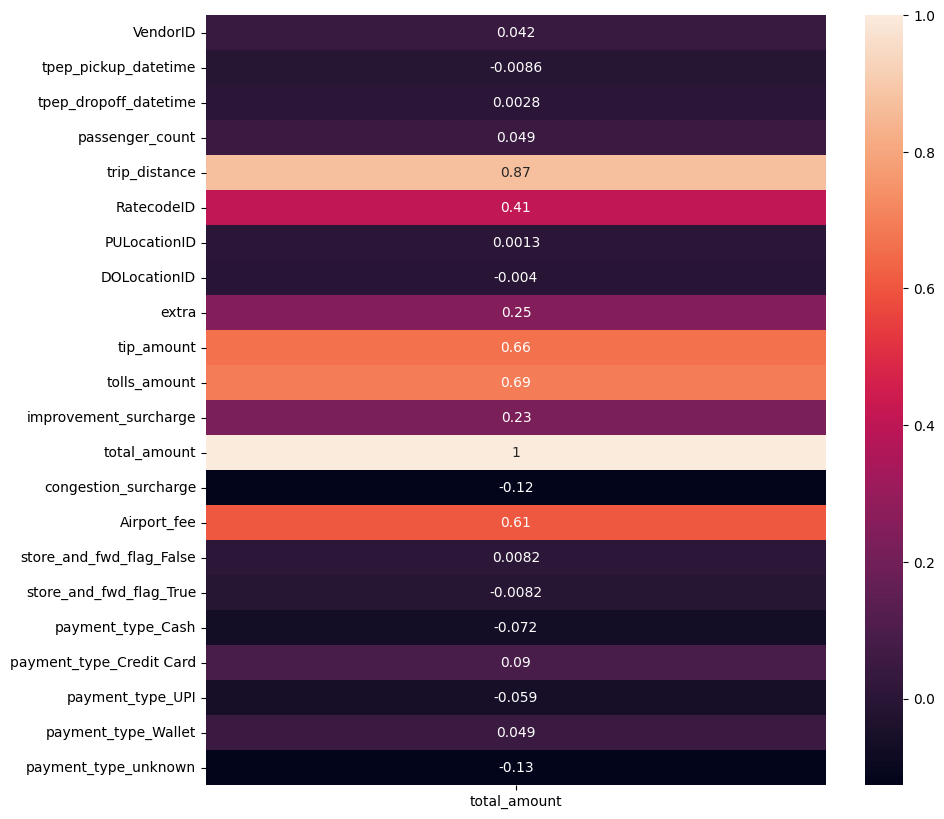

In [43]:
import seaborn as sns
corr = train.corr()[['total_amount']]
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [44]:
# print column names from corr if the abs value is greater than 0.1
corr_cols = [i for i in corr[abs(corr['total_amount']) > 0.1].index]
# for i in corr_cols:
#     print(i)

These are the columns that the heatmap detremined to have correation of over 0.1. We will use these colmns and any related columns.

In [45]:
# print cols not in corr_cols
# for i in train.columns:
#     if i not in corr_cols:
#         print(i)

We will drop all of these. We will also drop payment_type_unknown as well as it also has a fairly low correleation.

In [46]:
# drop columns not in corr_cols
for i in train.columns:
    if i not in corr_cols:
        train.drop(i, axis=1, inplace=True)

train.drop('payment_type_unknown', axis=1, inplace=True)

train.head()

,trip_distance,RatecodeID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2.14,1.0,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,2.70,1.0,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1.15,1.0,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0.40,1.0,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1.10,1.0,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [47]:
# train.head()

These are the columns we will we using. Now we'll make a 80:20 train/test split.

In [48]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(train.drop('total_amount', axis=1), train['total_amount'], test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training data shape: ", train_data.shape)
print("Training labels shape: ", train_labels.shape)
print("Testing data shape: ", test_data.shape)
print("Testing labels shape: ", test_labels.shape)
train_data.head()

Training data shape:  (139722, 8)
Training labels shape:  (139722,)
Testing data shape:  (34931, 8)
Testing labels shape:  (34931,)


,trip_distance,RatecodeID,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
34585,3.20,1.0,5.0,7.035102,0.0,1.0,2.5,0.0
116400,3.16,1.0,0.0,11.083254,0.0,1.0,2.5,0.0
139616,1.56,1.0,1.0,3.098152,0.0,1.0,2.5,0.0
92237,3.34,1.0,0.0,7.780267,0.0,1.0,2.5,0.0
149758,1.42,1.0,2.5,0.665760,0.0,1.0,2.5,0.0


## Now for the models
Model 1: KNN
We know KNN is effected by the curse of dimentionality so we will drop a few columns from the data.

In [49]:
train_data_knn = train_data.copy()
test_data_knn = test_data.copy()
train_labels_knn = train_labels.copy()
test_labels_knn = test_labels.copy()

In [50]:
# keep only trip_distance, RatecodeID, tip_amount, tolls_amount, Airport_fee

train_data_knn = train_data_knn[['trip_distance', 'RatecodeID', 'tip_amount', 'tolls_amount', 'Airport_fee']]
test_data_knn = test_data_knn[['trip_distance', 'RatecodeID', 'tip_amount', 'tolls_amount', 'Airport_fee']]

In [51]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error

# knn = KNeighborsRegressor(n_neighbors=3)
# knn.fit(train_data_knn, train_labels)


# test_predictions = knn.predict(test_data_knn)
# rmse = mean_squared_error(test_labels, test_predictions, squared=False)

# print("Model RMSE: ", rmse)

In [52]:
# knn = KNeighborsRegressor(n_neighbors=3)
# knn.fit(train_data, train_labels)


# test_predictions = knn.predict(test_data)
# rmse = mean_squared_error(test_labels, test_predictions, squared=False)

# print("Model RMSE: ", rmse)

We can see that despite the reduction in dimentions, the model is running around the same speed, almost within margin of error. Furthermore the accuracy is worse on the reduced dimentions. We will not the reduced dataset.

Previous runs have shown the best params as:

`Best parameters:  {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}`

So this grid search will be very reduced for demonstration. The original grid search to find the above parameters took over 10 minutes to run.

In [53]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_neighbors' : np.arange(3, 4),
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto'],
#     'leaf_size': np.arange(1, 2),
#     'p' : [1],
#     'n_jobs': [-1]
# }

# knn = KNeighborsRegressor()
# knn_cv = GridSearchCV(knn, param_grid, cv=5)
# knn_cv.fit(train_data, train_labels)

# best_params = knn_cv.best_params_
# print("Best parameters: ", best_params)

# best_score = knn_cv.best_score_
# print("Best score: ", best_score)

In [54]:
# model = knn_cv.best_estimator_
# model.fit(train_data, train_labels)

Not keeping SVM because it takes too long to run. And wasn't very accurate.

Model 2: CART

In [55]:
train_data_cart = train_data.copy()
test_data_cart = test_data.copy()
train_labels_cart = train_labels.copy()
test_labels_cart = test_labels.copy()

In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# # Initialize the DecisionTreeRegressor
# clf = DecisionTreeRegressor(random_state=42)

# # Fit the model using the training data
# clf.fit(train_data_cart, train_labels_cart)

# # Predict the target for the test data
# test_predictions = clf.predict(test_data_cart)

# # Calculate the RMSE of the model
# rmse = mean_squared_error(test_labels_cart, test_predictions, squared=False)

# print("Model RMSE: ", rmse)

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['squared_error','friedman_mse'],
    'max_depth': [1, 15, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

clf = DecisionTreeRegressor(random_state=42)
clf_cv = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
clf_cv.fit(train_data_cart, train_labels_cart)

print("Best param:", clf_cv.best_params_)
print("Best score:", clf_cv.best_score_)

Best param: {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 2}
Best score: 0.9392400073105167


In [58]:
# model = clf_cv.best_estimator_
# model.fit(train_data_cart, train_labels_cart)
# test_predictions = model.predict(test_data_cart)
# rmse = mean_squared_error(test_labels_cart, test_predictions, squared=False)
# print("Model RMSE: ", rmse)

This has worked well. Now trying bagging and boosting. We will carry over the Descision Tree parameters.

In [59]:
train_data_bgbt = train_data.copy()
test_data_bgbt = test_data.copy()
train_labels_bgbt = train_labels.copy()
test_labels_bgbt = test_labels.copy()

In [60]:
# from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor

# bag_reg = BaggingRegressor(
#     clf_cv.best_estimator_,
#     n_estimators=500,
#     max_samples=100,
#     bootstrap=True,
#     random_state=42,
# )
# bag_reg.fit(train_data_bgbt, train_labels_bgbt)
# bag_pred = bag_reg.predict(test_data_bgbt)
# bag_rmse = mean_squared_error(test_labels_bgbt, bag_pred, squared=False)

# print("Bagging Regressor RMSE: ", bag_rmse)

In [61]:
# ada_reg = AdaBoostRegressor(
#     clf_cv.best_estimator_,
#     n_estimators=200,
#     learning_rate=0.5,
#     random_state=42,
# )
# ada_reg.fit(train_data_bgbt, train_labels_bgbt)
# ada_pred = ada_reg.predict(test_data_bgbt)
# ada_rmse = mean_squared_error(test_labels_bgbt, ada_pred, squared=False)

# print("AdaBoost Regressor RMSE: ", ada_rmse)

We will use boosting as the RMSE is lower.

In [62]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.3, 0.5, 0.7],
#     'random_state': [42]
# }

# ada_grid = GridSearchCV(AdaBoostRegressor(clf_cv.best_estimator_), param_grid, cv=2, n_jobs=-1)

# ada_grid.fit(train_data_bgbt, train_labels_bgbt)
# print("Best param:", ada_grid.best_params_)
# print("Best score:", ada_grid.best_score_)

This is even better! Now we'll try MLP and after that random forest.

In [63]:
train_data_mlp = train_data.copy()
test_data_mlp = test_data.copy()
train_labels_mlp = train_labels.copy()
test_labels_mlp = test_labels.copy()

In [64]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Initialize the MLPRegressor
# mlp_reg = MLPRegressor(random_state=42, max_iter=100, early_stopping=True, learning_rate='adaptive', learning_rate_init=0.02)

# # Fit the model using the training data
# mlp_reg.fit(train_data_mlp, train_labels_mlp)

# # Predict the target for the test data
# mlp_pred = mlp_reg.predict(test_data_mlp)

# # Calculate the RMSE of the model
# rmse = mean_squared_error(test_labels_mlp, mlp_pred, squared=False)

# print("Model RMSE: ", rmse)

In [65]:
# param_grid = {
#     'learning_rate_init': [0.01, 0.02],
#     'learning_rate': ['adaptive'],
#     'activation': ['relu', 'tanh']
# }

# grid_mlp = GridSearchCV(MLPRegressor(random_state=42, max_iter=100, early_stopping=True), param_grid, cv=2, n_jobs=-1)

# grid_mlp.fit(train_data_mlp, train_labels_mlp)
# print("Best param:", grid_mlp.best_params_)
# print("Best score:", grid_mlp.best_score_)

MLP had a terrible score! It also took very long to run. Let's try random forest!

In [66]:
train_data_randf = train_data.copy()
test_data_randf = test_data.copy()
train_labels_randf = train_labels.copy()
test_labels_randf = test_labels.copy()

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1)

# Fit the model using the training data
rf_reg.fit(train_data_randf, train_labels_randf)

# Predict the target for the test data
rf_pred = rf_reg.predict(test_data_randf)

# Calculate the RMSE of the model
rmse = mean_squared_error(test_labels_randf, rf_pred, squared=False)

print("Random Forest RMSE: ", rmse)

Random Forest RMSE:  5.579208023695183


In [69]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'bootstrap': [True],
    'random_state': [42],
    'n_jobs': [-1],
    'oob_score': [True, False]
}

grid_ranf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=-1)

grid_ranf.fit(train_data_randf, train_labels_randf)
print("Best param:", grid_ranf.best_params_)
print("Best score:", grid_ranf.best_score_)

Best param: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best score: 0.950876108522646


In [70]:
model = grid_ranf.best_estimator_
model.fit(train_data_bgbt, train_labels_bgbt)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=42)

In [71]:
# test.head()

In [72]:
# keep only the columns in train except total_amount
test = test[train.drop('total_amount', axis=1).columns]

In [73]:
test.head()

,trip_distance,RatecodeID,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
0,4.95,1.0,1.0,6.067612,0.0,1.0,2.5,0.0
1,2.10,1.0,2.5,6.191269,0.0,1.0,2.5,0.0
2,0.95,1.0,2.5,3.983872,0.0,1.0,2.5,0.0
3,0.80,1.0,3.5,6.839341,0.0,1.0,2.5,0.0
4,4.01,1.0,0.0,1.468943,0.0,1.0,0.0,0.0


In [74]:
# put mean in nan values
test['RatecodeID'].fillna(test['RatecodeID'].mode()[0], inplace=True)
test['congestion_surcharge'].fillna(test['congestion_surcharge'].mode()[0], inplace=True)
test['Airport_fee'].fillna(test['Airport_fee'].mode()[0], inplace=True)

In [75]:
#predictions
predictions = model.predict(test)
predictions.shape
predictions.shape[0]+1

50001

In [76]:
print(predictions[:])

[34.74759735 24.8464364  16.36262541 ... 21.22975117 38.28472047
 16.32130298]


In [77]:
# Create a DataFrame from predictions with an ID column
sub_df = pd.DataFrame({
    'ID': range(1, len(predictions) + 1),
    'total_amount': predictions
})

sub_df.head()

,ID,total_amount
0,1,34.747597
1,2,24.846436
2,3,16.362625
3,4,14.785396
4,5,27.160616


In [78]:
sub_df.to_csv('submission.csv', index=False)

In [79]:
# import sklearn as sk
# import xgboost as xgb
# import imblearn as imb
# import scipy as sp
# import pickle as pkl
# import regex as re
# import seaborn as sns
# import matplotlib as mpl
# import lightgbm as lgb